# UCI Air Quality - Relative Humidity Estimator

In the previous notebook (`UCI Air Quality - Exploratory Data Analysis`)
we delved into UCI repository's Air Quality dataset, gaining insights about the behavior of pollutant concentration levels and their correlation with Relative Humidity and Temperature.


Now, our focus shifts to constructing a model to predict Relative Humidity. Our main goal in this notebook is to develop a method for estimating Relative Humidity patterns based on pollutant concentration levels, temperature and datatetime data.

## Contents

1. [**Structuring Data**](#1.-Structuring-Data)
2. [**Performance Comparison**](#2.-Performance-Comparison)
3. [**Feature Importance**](#3.-Feature-Importance)
4. [**Feature Selection**](#3.-Feature-Selection)

### Importing Libraries

In [1]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error


import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings('ignore') 

sns.set(font_scale=1.2)
sns.set_palette("pastel")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Structuring Data
___

In the previous notebook, we completed preprocessing tasks on the dataset, which involved filling missing values and adding additional columns. 

Now, let's proceed by loading the CSV file containing the preprocessed data.

In [2]:
df = pd.read_csv("./data/cleaned-air-quality-dataset.csv")

We can see that our dataframe contains no missing values and we also introduces several additional columns, including Year, Month, DayOfWeek and Hour.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   C6H6(GT)       9357 non-null   float64
 3   PT08.S2(NMHC)  9357 non-null   float64
 4   NOx(GT)        9357 non-null   float64
 5   PT08.S3(NOx)   9357 non-null   float64
 6   NO2(GT)        9357 non-null   float64
 7   PT08.S4(NO2)   9357 non-null   float64
 8   PT08.S5(O3)    9357 non-null   float64
 9   T              9357 non-null   float64
 10  RH             9357 non-null   float64
 11  AH             9357 non-null   float64
 12  Year           9357 non-null   int64  
 13  Month          9357 non-null   int64  
 14  DayOfWeek      9357 non-null   int64  
 15  Hour           9357 non-null   int64  
dtypes: float64(12), int64(4)
memory usage: 1.1 MB


To validate our predictor, we will begin by dividing our data into training and testing datasets. Given the temporal chronological nature of our data, we will alocate the first 80% of the data to the training set and the remaining 20% to the testing set.

In [4]:
train_portion = 0.8
split_index = int(train_portion * len(df))

df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

In [5]:
X_train, y_train = df_train.drop(["RH","AH"],axis=1), df_train["RH"] 
X_test, y_test = df_test.drop(["RH","AH"],axis=1), df_test["RH"] 

## 2. Performance Comparison
___

In this section, four Regression Algorithms have been selected for evaluation. 

A pipeline has been implemented, consisting of two steps:a Standard Scaler that is applied to normalize the data, followed by the selected regression algorithm.

Additionally, a Grid Search is applied to select the best hyperparameters for the model. This approach allows for a systematic comparison of the performance of different algorithms while optimizing the model parameters to achieve the best possible results.

In [6]:
pipelines = {
    "Linear Regression": Pipeline([("scaler", StandardScaler()), ("regressor", LinearRegression())]),
    "SVR": Pipeline([("scaler", StandardScaler()), ("regressor", SVR())]),
    "Random Forest":Pipeline([("scaler", StandardScaler()), ("regressor", RandomForestRegressor())]),
    "Gradient Boosting": Pipeline([("scaler", StandardScaler()), ("regressor", GradientBoostingRegressor())])
}

param_grid = {
    "Linear Regression":{},
    "SVR": {
        "regressor__kernel": ["linear", "rbf"],
        "regressor__C": [0.1, 1, 10],
        "regressor__epsilon": [0.01, 0.1, 0.5]
    },
    "Random Forest":{
        "regressor__n_estimators": [100, 200, 300],
        "regressor__max_depth": [None, 5, 10]
    },
    "Gradient Boosting":{
        "regressor__n_estimators": [100, 200, 300],
        "regressor__max_depth": [3, 5, 7],
        "regressor__learning_rate": [0.01, 0.1, 0.5]
    }
}


results = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grid[name], cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    results[name] = {
        "Melhores parâmetros": grid_search.best_params_,
        "Melhor score (MSE)": -grid_search.best_score_
    }

for name, result in results.items():
    print(f"Resultados para {name}:")
    for metric, value in result.items():
        print(f"{metric}: {value}")
    print()

Resultados para Linear Regression:
Melhores parâmetros: {}
Melhor score (MSE): 130.5186486279611

Resultados para SVR:
Melhores parâmetros: {'regressor__C': 10, 'regressor__epsilon': 0.01, 'regressor__kernel': 'rbf'}
Melhor score (MSE): 77.43497457392549

Resultados para Random Forest:
Melhores parâmetros: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Melhor score (MSE): 147.0867616247293

Resultados para Gradient Boosting:
Melhores parâmetros: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300}
Melhor score (MSE): 135.27150498065802



The SVR algorithm demonstrated the best performance, with a MSE of 77.43 when running a 3-fold cross-validation on the train sample.

Next, we will evaluate its performance on the test sample:

In [7]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE on test sample: {mse}")

MSE on test sample: 84.82838177612012


In assessing the efficacy of a Data Science solution for businesses, the MSE metric may not offer the most intuitive insight. Hence, we complement it with two additional metrics: MAE, representing the mean absolute error, and MAPE, reflecting the mean absolute percentage error.

In [8]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {round(mape*100,2)}% (average percentage difference between predicted and actual values)")
print(f"MAE: {mae:0.2f} (average absolute difference between predicted and actual values)")

MAPE: 17.29% (average percentage difference between predicted and actual values)
MAE: 7.37 (average absolute difference between predicted and actual values)


In [9]:
results_df = pd.DataFrame(y_pred, columns=["y_pred"])
results_df = pd.concat([y_test.reset_index(drop=True), results_df], axis=1)
results_df.rename(columns={"RH":"y_test"}, inplace=True)
results_df

,y_test,y_pred
0,32.5,33.682745
1,33.0,31.137922
2,35.0,35.739149
3,40.9,45.939187
4,38.5,48.629820
...,...,...
1867,29.3,30.889292
1868,23.7,16.581720
1869,18.3,14.841248
1870,13.5,18.056319


### Residual Plot

Analyzing the residual plot, we observe in the histogram plot below that the residuals exhibit a normal distribution. This symmetric distribution around zero indicates that the model adequately captures the main patterns and sources of variation in data. Futhermore, it suggests that the errors are random and independent.

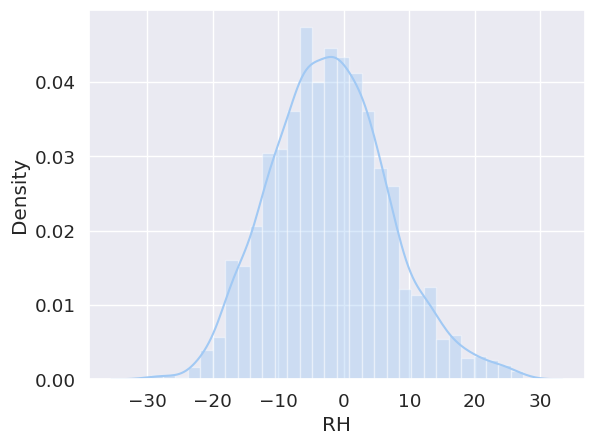

In [10]:
residual = y_test - y_pred
sns.distplot(residual)
plt.show()

## 3. Feature Importance
___

Upon evaluating the model's performance, we can now assess the importance of the features. To do so, we initially examine the feature_importances parameter provided by the algorithm.

In [11]:
feature_importances = best_model.named_steps["regressor"].feature_importances_

In [12]:
df_importance = pd.DataFrame(feature_importances, index=X_train.columns, columns=["importance"])
df_importance_sorted = df_importance.sort_values(by="importance", ascending=False)

In [13]:
df_importance_sorted

,importance
T,0.564903
PT08.S4(NO2),0.136839
Month,0.115386
Hour,0.043284
PT08.S2(NMHC),0.036895
NO2(GT),0.030421
PT08.S3(NOx),0.019011
PT08.S5(O3),0.013343
PT08.S1(CO),0.011764
NOx(GT),0.011369


As expected, the Temperature variable proves to be a highly influential factor for the estimation of Relative Humidity. 

Additionaly, the inclusion of the new variables Month and Hour also contributed significantly to the model's predictive ability.

Meanwhile, the majority of pollutant concentration levels showed minimal contribution.

### SHAP

We can also assess the performance of features using the SHAP library. In the graph below, features are arranged from highest to lowest effect on the prediction. The analysis considers the absolute SHAP value, ensuring that the impact of features on the prediction, whether positive or negative, is accounted for.

In [14]:
explainer = shap.Explainer(best_model.named_steps["regressor"].predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 1873it [05:03,  5.99it/s]                                                         


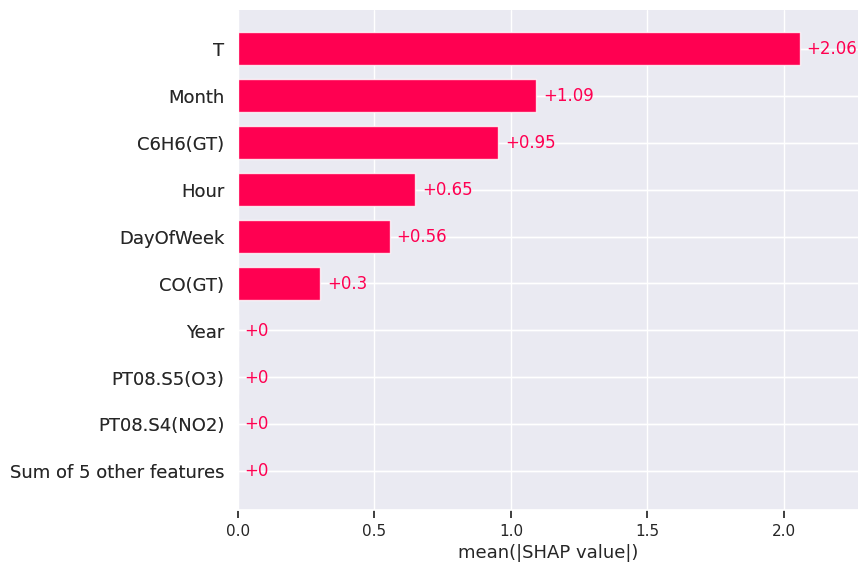

In [15]:
shap.plots.bar(shap_values)

### Feature Selection

Having analyzed the feature importance plots generated by both the algorithm and the SHAP library, it's evident that not all features significantly influence the prediction. 

Features with lower importance values could be considered for removal to simplify the data complexity.

To test this alternative, we selected only the primary features identified by the feature importance algorithms and trained the model again.

In [16]:
best_features = ["T", "PT08.S4(NO2)", "CO(GT)", "Month", "Hour", "PT08.S2(NMHC)", "C6H6(GT)"]

In [17]:
X_train, y_train = df_train[best_features], df_train["RH"] 
X_test, y_test = df_test[best_features], df_test["RH"] 

In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(C=10, epsilon=0.01, kernel='rbf'))
])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=10, epsilon=0.01))])

In [20]:
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Evaluation metrics on test:")
print(f"- MSE: {mse:0.2f}")
print(f"- MAPE: {round(mape*100,2)}% (average percentage difference between predicted and actual values)")
print(f"- MAE: {mae:0.2f} (average absolute difference between predicted and actual values)")

Evaluation metrics on test:
- MSE: 201.31
- MAPE: 25.31% (average percentage difference between predicted and actual values)
- MAE: 11.65 (average absolute difference between predicted and actual values)


In [21]:
results_df = pd.DataFrame(y_pred, columns=["y_pred"])
results_df = pd.concat([y_test.reset_index(drop=True), results_df], axis=1)
results_df.rename(columns={"RH":"y_test"}, inplace=True)
results_df

,y_test,y_pred
0,32.5,42.283631
1,33.0,42.504528
2,35.0,43.063600
3,40.9,46.513045
4,38.5,47.134199
...,...,...
1867,29.3,16.432320
1868,23.7,16.019192
1869,18.3,17.672822
1870,13.5,19.292706
